In [1]:
# Enable autoreload extension
%load_ext autoreload
# Automatically reload all modules (except built-ins) before executing code
%autoreload 2

# Necessary

- Create VE
- Create dataset

In [2]:
import sys
import os
sys.path.append(os.path.abspath("/home/gdallagl/myworkdir/ESMSec/utils"))  # Adds current folder to Python path

import utils.my_functions as mf
import utils.models as my_models
import utils.dataset as my_dataset
import utils.embeddings_functions as my_embs
import utils.scanning as my_scanning

import torch
import torch.nn as nn
import random
import time
from torch.utils.data import TensorDataset
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from transformers import AutoModel, AutoTokenizer
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import seaborn as sns

print(torch.__version__)

2.5.0+cu121


In [3]:
# Configuration / hyperparameters
config = {
    "SEED": 42,             # Random seed

    "NUM_EPOCHS": 300,       # Total Epochs in training
    "EVAL_EPOCH_FREQ": 50,   # Evaluation frequency
    "BATCH_SIZE": 64,       # Batch size
    "LR": 1e-4,             # Learning rate
    "LR_DECAY_GAMMA": 0.8,    # Learning rate decay
    "LR_DECAY_STEPS_EPOCHS": 50, # Learning rate decay steps
    "L2_REG": 0.01, # avoid to big weigths (imprve generalisation) (1 - weigths)

    "PROTEIN_MAX_LENGTH": 1000, # Max protein length (for ESM2)
    "PRETRAIN_ESM_CHECKPOINT_NAME": "facebook/esm2_t12_35M_UR50D",#"facebook/esm2_t33_650M_UR50D", #"facebook/esm2_t12_35M_UR50D", #"facebook/esm2_t6_8M_UR50D", # ESM2 model name --> if nto isntalled, autocally dowlaoded
    "PRETRAIN_ESM_CACHE_DIR": "/home/gdallagl/myworkdir/data/esm2-models", # ESM2 model cache dir
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu", # Device to use (cuda or cpu)

    "DATASET_PATH":'/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/dataset-cell-cycle_freeman.csv', #"/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/cell-cycle-dataset_2:3.csv",  #"/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/only-guaranteed_cell-cycle-dataset_2:3.csv", #"/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/cell-cycle-dataset_2:3.csv", 
    "PATH_TO_SAVE_MODEL": "/home/gdallagl/myworkdir/ESMSec/data/trained_models/cell_cycle_trained_model.pth", # Path to save the model
    
    "TYPE_HEAD":"LR",# "attention", #"MLP", "LR"
    "TYPE_EMB_FOR_CLASSIFICATION": "cls", #"concat(agg_mean, agg_max)", #"contextualized_embs", #"concat(agg_mean, agg_max)",cls
    "FROM_PRECOMPUTED_EMBS": True,
}
config["PRECOMPUTED_EMBS_PATH"] = os.path.join(
    os.path.dirname(config["DATASET_PATH"]),  # base folder of dataset
    "precomputed_embs",                       # subfolder name
    f"{os.path.basename(config['DATASET_PATH']).split('.')[0]}_embs_"
    f"{config['PRETRAIN_ESM_CHECKPOINT_NAME'].replace('/', '-')}_"
    f"{config['TYPE_EMB_FOR_CLASSIFICATION']}.pt"
)

# Initializations
random.seed(config["SEED"])
np.random.seed(config["SEED"])
torch.manual_seed(config["SEED"])
torch.backends.cudnn.benchmark = True 

# Instantiate ESM model

In [4]:
# Load pre-trained ESM model
esm_model = AutoModel.from_pretrained(config["PRETRAIN_ESM_CHECKPOINT_NAME"],  cache_dir=config["PRETRAIN_ESM_CACHE_DIR"]).to(config["DEVICE"])
# Checj whcih model has been moded by AutoModel.from_pretrained()
print("\nESM model type", type(esm_model), "\n")

# Load relative tokenizer
tokenizer = AutoTokenizer.from_pretrained(config["PRETRAIN_ESM_CHECKPOINT_NAME"])

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



ESM model type <class 'transformers.models.esm.modeling_esm.EsmModel'> 



# Load dataset and Tokenize

In [5]:
data = pd.read_csv(config["DATASET_PATH"])

num_samples = data.shape[0]

# ATTENTION:trucnat seqq to enforce max conetxt of EMS
data["truncated_sequence"] = data.sequence.apply(my_dataset.truncate_sequence)

# tokenize truncated seqeunces
    # ATTENTION: they a
print("Tokenizing...")
encoded = tokenizer(
    list(data.truncated_sequence),
    padding='max_length',
    max_length=config["PROTEIN_MAX_LENGTH"],
    truncation=True,
    return_tensors="pt"
)
# add to dict
input_ids_tensor = encoded["input_ids"]          # shape: (N, L)
attention_mask_tensor = encoded["attention_mask"]
# add to df
data["input_ids"] = [tensor for tensor in encoded["input_ids"]]
data["attention_mask"] = [tensor for tensor in encoded["attention_mask"]]

#####################

# save all information needed to tothe model
cache_data = {
    'protein': list(data.protein),
    'label': torch.tensor(data.label.values),
    'set': list(data.set),
    'sequence': list(data.sequence),
    'truncated_sequence': list(data.truncated_sequence),
    'input_ids': input_ids_tensor,
    'attention_mask': attention_mask_tensor,
    'embedding': torch.zeros((num_samples, 1), dtype=torch.float32) # FAKE
}


Tokenizing...


# Add or Create embs

Only if "from_precomputed_embs" is True

In [6]:
# add or use precomputed embs only if needed
if config["FROM_PRECOMPUTED_EMBS"]:

    if not os.path.exists(config["PRECOMPUTED_EMBS_PATH"]):
        print("Embeddings file not found. Calculating embs...")
        
        esm_model.eval()

        # Create dataloader for batched processing
        batch_size = config.get("BATCH_SIZE", 32)
        dataloader = my_dataset.create_dataloader(
            cache_data,
            batch_size=batch_size,
            shuffle=False
        )

        embeddings_list = []
        protein_names = []

        for batch in tqdm(dataloader, desc="Processing protein batches"):
            batch_input_ids = batch["input_ids"].to(config["DEVICE"])
            batch_attention_mask = batch["attention_mask"].to(config["DEVICE"])
            batch_proteins = batch["name"]

            with torch.no_grad():
                outputs_esm = esm_model(
                    input_ids=batch_input_ids, 
                    attention_mask=batch_attention_mask, 
                    return_dict=True
                )

                batch_embeddings = my_models.get_embs_from_context_embs( 
                                                            context_embs_esm = outputs_esm.last_hidden_state,
                                                            attention_mask = batch_attention_mask,
                                                            type_embs = config["TYPE_EMB_FOR_CLASSIFICATION"],
                                                            exclude_cls=True)

                # Store batch results
                protein_names.extend(batch_proteins)
                embeddings_list.append(batch_embeddings.detach().cpu())

        print("Saving embeddings to fast PyTorch cache...")
        torch.save({
            "protein": protein_names,
            "embedding": [e.cpu() for e in embeddings_list]  # list of tensors
        }, config["PRECOMPUTED_EMBS_PATH"])

        # # Concatenate all batch embeddings
        # all_embeddings = torch.cat(embeddings_list, dim=0)
        # emb_dict = {
        #     'protein': protein_names,
        #     'embedding': all_embeddings
        # }
        # torch.save(emb_dict, config["PRECOMPUTED_EMBS_PATH"])

    print(f"Reading back from file: {config['PRECOMPUTED_EMBS_PATH']}...")
    emb_dict = torch.load(config["PRECOMPUTED_EMBS_PATH"], weights_only=False)
    cache_data["embedding"] = torch.cat(emb_dict["embedding"], dim=0) #emb_dict["embedding"]

else:
    print("No precomputed embs")

Reading back from file: /home/gdallagl/myworkdir/ESMSec/data/cell_cycle/precomputed_embs/dataset-cell-cycle_freeman_embs_facebook-esm2_t12_35M_UR50D_cls.pt...


In [7]:
# Degfine classifcatio head dimesion

if config["FROM_PRECOMPUTED_EMBS"]:
    first_emb_shape = cache_data["embedding"].shape  # (N, L, D)
    if len(first_emb_shape) == 1:
        # Aggregated embedding (e.g., [D])
        config["PRECOMPUTED_EMBS_DIM"] = int(first_emb_shape[0])
    elif len(first_emb_shape) == 2:
        # Aggregated per sequence (e.g., [L, D])
        config["PRECOMPUTED_EMBS_DIM"] = int(first_emb_shape[1])
    elif len(first_emb_shape) == 3:
        # Contextualized embeddings (N, L, D) → use D
        config["PRECOMPUTED_EMBS_DIM"] = int(first_emb_shape[2])
else:
    # dim embessign sins the output of esm
    config["PRECOMPUTED_EMBS_DIM"] = esm_model.embeddings.word_embeddings.embedding_dim
    #fake embs
    cache_data["embedding"] = torch.zeros((num_samples, 1), dtype=torch.float32)

print(config["PRECOMPUTED_EMBS_DIM"])

480


Original: 437, Truncated: 437, Tokenized (no pad): 439
Original: 391, Truncated: 391, Tokenized (no pad): 393
Original: 523, Truncated: 523, Tokenized (no pad): 525


protein                  : list length 9524
label                    : Tensor shape (9524,)
set                      : list length 9524
sequence                 : list length 9524
truncated_sequence       : list length 9524
input_ids                : Tensor shape (9524, 1000)
attention_mask           : Tensor shape (9524, 1000)
embedding                : Tensor shape (9524, 480)


<Axes: >

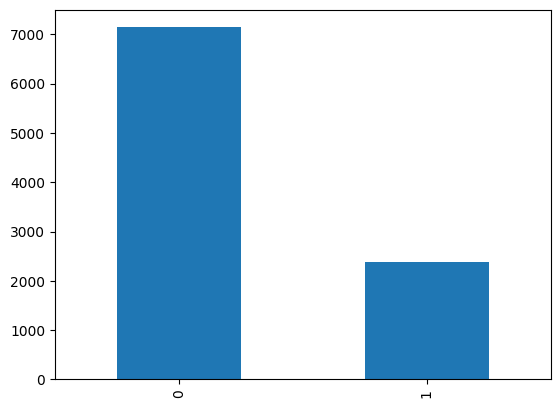

In [8]:
# Plotting

for i in range(3):
    seq = data.sequence.iloc[i]
    trunc_seq = data.truncated_sequence.iloc[i]
    input_ids = input_ids_tensor[i]
    print(f"Original: {len(seq)}, Truncated: {len(trunc_seq)}, Tokenized (no pad): {(input_ids != tokenizer.pad_token_id).sum().item()}")

print("\n")
for key, value in cache_data.items():
    if isinstance(value, torch.Tensor):
        print(f"{key:25s}: Tensor shape {tuple(value.shape)}")
    elif isinstance(value, pd.Series):
        print(f"{key:25s}: pandas Series, length {len(value)}")
    elif isinstance(value, (list, tuple)):
        print(f"{key:25s}: list length {len(value)}")
    else:
        print(f"{key:25s}: type {type(value)}")

data["label"].value_counts().reset_index(drop="True").plot(kind='bar')

# Create DataLoaders

In [9]:
# ATTENTION: the name of the cols in the df must be speicifc
train_indices = [i for i, s in enumerate(cache_data["set"]) if s == "train"] # select indices
train_cache_data = my_dataset.subset_data_dict(cache_data, train_indices) # create cache_data subset
train_dl = my_dataset.create_dataloader(train_cache_data, config["BATCH_SIZE"], shuffle=True) # create dataloader

valid_indices = [i for i, s in enumerate(cache_data["set"]) if s == "val"] 
valid_cache_data = my_dataset.subset_data_dict(cache_data, valid_indices) 
valid_dl = my_dataset.create_dataloader(valid_cache_data, config["BATCH_SIZE"], shuffle=True) 

test_indices = [i for i, s in enumerate(cache_data["set"]) if s == "test"] 
test_cache_data = my_dataset.subset_data_dict(cache_data, test_indices) 
test_dl = my_dataset.create_dataloader(test_cache_data, config["BATCH_SIZE"], shuffle=True) 



# little check:
batch = next(iter(train_dl))

input_ids = batch["input_ids"]
attention_mask = batch["attention_mask"]
labels = batch["label"]
names = batch["name"]
embs = batch["embs"]

print("=== Batch Information ===")
print(f"Batch size: {labels.shape[0]}\n")
print(f"Input IDs: Tensor, shape = {tuple(input_ids.shape)}, dtype = {input_ids.dtype}")
print(f"Attention mask: Tensor, shape = {tuple(attention_mask.shape)}, dtype = {attention_mask.dtype}")
print(f"Labels: Tensor, shape = {tuple(labels.shape)}, dtype = {labels.dtype}")
print(f"First 5 labels: {labels[:5]}")
print(f"Names: List, length = {len(names)}, first 5 = {names[:5]}")
print(f"Embeddings: Tensor, shape = {tuple(embs.shape)}, dtype = {embs.dtype}")


=== Batch Information ===
Batch size: 64

Input IDs: Tensor, shape = (64, 1000), dtype = torch.int64
Attention mask: Tensor, shape = (64, 1000), dtype = torch.int64
Labels: Tensor, shape = (64,), dtype = torch.int64
First 5 labels: tensor([1, 0, 0, 0, 0])
Names: List, length = 64, first 5 = ['P21127', 'P54289', 'Q9UBF9', 'Q6NXP2', 'P01920']
Embeddings: Tensor, shape = (64, 480), dtype = torch.float32


# Instantiate Full model

In [10]:
# initialise model (ESM+ HEad)
net = my_models.EsmDeepSec(esm_model, 
                           type_head=config["TYPE_HEAD"],
                           type_emb_for_classification=config["TYPE_EMB_FOR_CLASSIFICATION"],
                           from_precomputed_embs=config["FROM_PRECOMPUTED_EMBS"],
                           precomputed_embs_dim=config["PRECOMPUTED_EMBS_DIM"]
                           ).to(config["DEVICE"])
# hidden dim of final embeggin of each aa after trnafoerm 
print(net.class_head)

# Block ESM paramters to be trained
if net.esm_model is not None:
    print("\nESM hidden dim", net.ESM_hidden_dim, "\n")
    for param in net.esm_model.parameters():
        param.requires_grad = False

LogisticRegressionHead(
  (classifier): Linear(in_features=480, out_features=2, bias=True)
)

ESM hidden dim 480 



# Define weighted loss fucntion

In [11]:
# Get class counts (ordered by label)
class_counts = data[data.set == "train"].label.value_counts().sort_index()
print("Class counts (ordered by label):", class_counts.to_dict())

# Convert counts to list [count_class_0, count_class_1]
class_counts_list = class_counts.tolist()

# Total number of samples
N = sum(class_counts_list)

# Compute class weights using w_i =  N / N_i
class_weights = torch.tensor([N / class_counts_list[0], N / class_counts_list[1]], dtype=torch.float)

# scale to avoid biased towrad class 1
#reduces bias toward class 1 while still giving minority class more importance.
class_weights = class_weights / class_weights.max()  # max weight = 1

# Move to device
class_weights = class_weights.to(config["DEVICE"])

# Print for sanity check
print(f"Class 0 count: {class_counts_list[0]}, weight: {class_weights[0]:.4f}")
print(f"Class 1 count: {class_counts_list[1]}, weight: {class_weights[1]:.4f}")

# Create loss function with class weights
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

Class counts (ordered by label): {0: 5715, 1: 1904}
Class 0 count: 5715, weight: 0.3332
Class 1 count: 1904, weight: 1.0000


In [12]:

# Get class counts (ordered by label)
class_counts = data[data.set == "train"].label.value_counts().sort_index()
print("Class counts (ordered by label):", class_counts.to_dict())

# Convert counts to list [count_class_0, count_class_1]
class_counts_list = class_counts.tolist()
count_0 = class_counts_list[0]
count_1 = class_counts_list[1]

# Total number of samples
N = sum(class_counts_list)

# 1. Compute initial class weights (inverse frequency: N / N_i)
# This gives the minority class (let's assume class 1) a higher value
initial_weights = torch.tensor([N / count_0, N / count_1], dtype=torch.float)

# 2. Normalize the initial weights so they sum to 1
sum_of_weights = torch.sum(initial_weights)
class_weights = initial_weights / sum_of_weights

# Move to device
class_weights = class_weights.to(config["DEVICE"])

# Print for sanity check
print(f"Class 0 count: {count_0}, weight: {class_weights[0]:.4f}")
print(f"Class 1 count: {count_1}, weight: {class_weights[1]:.4f}")
print(f"Sum of weights: {class_weights.sum():.4f}") # Should be 1.0000

# Create loss function with class weights
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

Class counts (ordered by label): {0: 5715, 1: 1904}
Class 0 count: 5715, weight: 0.2499
Class 1 count: 1904, weight: 0.7501
Sum of weights: 1.0000


In [13]:
loss_fn = nn.CrossEntropyLoss(weight=torch.Tensor([0.4, 0.6]).to(config["DEVICE"]))

In [14]:

# import torch.nn.functional as F

# class PULoss(nn.Module):
#     def __init__(self, pi_p=0.1):
#         """
#         pi_p: estimated fraction of positives in the dataset
#         """
#         super().__init__()
#         self.pi_p = pi_p

#     def forward(self, logits, labels):
#         """
#         logits: model outputs, shape [batch, 2] (raw logits)
#         labels: tensor, shape [batch], 1 for positives, 0 for unlabeled
#         """
#         # Separate positives and unlabeled
#         pos_mask = labels == 1
#         unl_mask = labels == 0

#         logits_p = logits[pos_mask]  # [num_pos, 2]
#         logits_u = logits[unl_mask]  # [num_unlabeled, 2]

#         if logits_p.numel() == 0 or logits_u.numel() == 0:
#             # fallback: just return normal CE on batch if no positives/unlabeled
#             return F.cross_entropy(logits, labels)

#         # Convert logits to class-1 probabilities
#         # torch.sigmoid(logit[:,1] - logit[:,0]) is equivalent to softmax class 1 probability
#         p_probs = torch.softmax(logits_p, dim=1)[:, 1]
#         u_probs = torch.softmax(logits_u, dim=1)[:, 1]

#         # BCE losses
#         loss_p = F.binary_cross_entropy(p_probs, torch.ones_like(p_probs), reduction='mean')
#         loss_p_as_neg = F.binary_cross_entropy(p_probs, torch.zeros_like(p_probs), reduction='mean')
#         loss_u = F.binary_cross_entropy(u_probs, torch.zeros_like(u_probs), reduction='mean')

#         # Non-negative risk estimator
#         risk = self.pi_p * loss_p + torch.clamp(loss_u - self.pi_p * loss_p_as_neg, min=0.0)

#         return risk
    
# # Get class counts (ordered by label)
# class_counts = data[data.set == "train"].label.value_counts().sort_index()
# print("Class counts (ordered by label):", class_counts.to_dict())

# # Convert counts to list [count_class_0, count_class_1]
# class_counts_list = class_counts.tolist()

# num_unlabeled = class_counts_list[0]
# num_positives = class_counts_list[1]
# pi_p = num_positives / (num_positives + num_unlabeled)

# # Print for sanity check
# print(pi_p)
    
# loss_fn = PULoss(pi_p=pi_p)


# Train

In [ ]:
#results = mf.train(net, train_dl, valid_dl, test_dl, loss_fn, config)
results = mf.train(net, train_dl, valid_dl, test_dl, loss_fn, config, from_precomputed_embs=config["FROM_PRECOMPUTED_EMBS"]) # precomputed are in the dataloder

### Plot


                         FINAL EVALUATION METRICS
Metric                    Train      Validation            Test
--------------- --------------- --------------- ---------------
Loss                     0.5302          0.7130          0.5368
Accuracy                 76.57%           0.00%          75.68%
Balanced Acc             65.68%           0.00%          65.30%
F1 Score                 0.4837          0.0000          0.4780
MCC                      0.3371          0.0000          0.3221


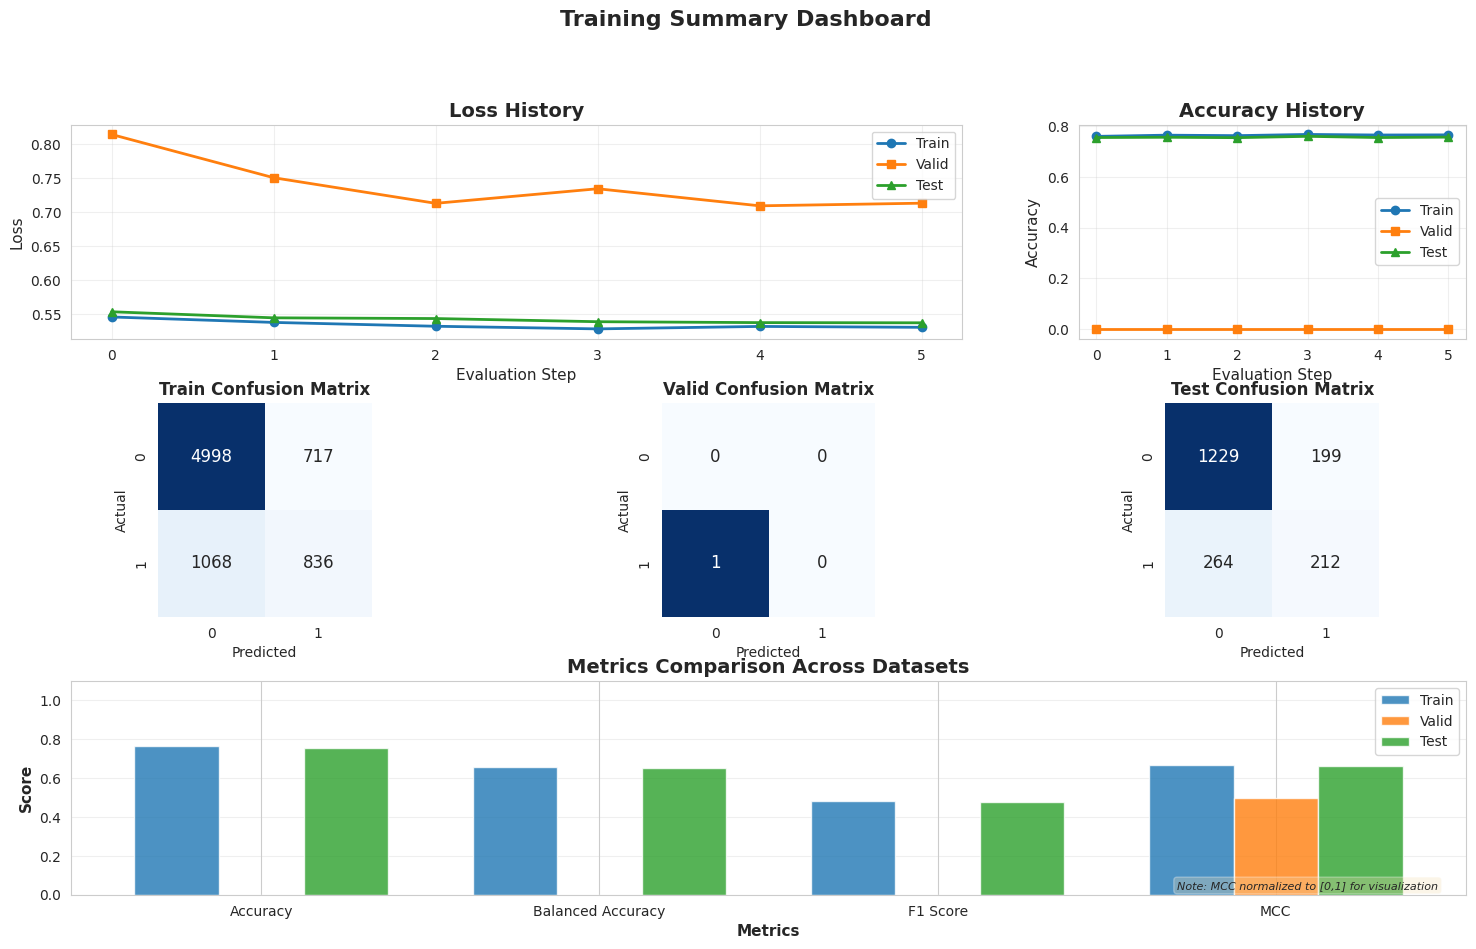


                         TEST SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Class 0     0.8232    0.8606    0.8415      1428
     Class 1     0.5158    0.4454    0.4780       476

    accuracy                         0.7568      1904
   macro avg     0.6695    0.6530    0.6598      1904
weighted avg     0.7463    0.7568    0.7506      1904




In [16]:
mf.summarize_training(*results)

### Save Model

In [17]:
torch.save(net, config["PATH_TO_SAVE_MODEL"])

### Load Model

In [18]:
net = torch.load(config["PATH_TO_SAVE_MODEL"])
net.eval()

/tmp/ipykernel_70450/3766833804.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load(config["PATH_TO_SAVE_MODEL"])


EsmDeepSec(
  (esm_model): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 480, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-11): 12 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=480, out_features=480, bias=True)
              (key): Linear(in_features=480, out_features=480, bias=True)
              (value): Linear(in_features=480, out_features=480, bias=True)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=480, out_features=480, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((480,), eps=1e-05, elementwise_affine=True)
          )
          (intermediate): EsmIntermediate(
            (dense): Linear(in_features=480, out_

### Umaps

Many types of embeddings can be extracted from different moments inside the model:

**1. From the ESM backbone**
- **ESM mean** → mean pooling over all token embeddings.  
- **ESM max** → max pooling over all token embeddings.  
- **ESM CLS** → embedding of the special classification token (first position).  
- **ESM tokens** → full sequence of token-level embeddings `[batch, seq_len, hidden_dim]`.  
- (Optional) **Layerwise embeddings** → extracting hidden states from multiple layers (e.g. last 4).

**2. From the feature head (AttentionClassificationHead)**
- **Feature mean** → mean pooling after attention + FFNN.  
- **Feature max** → max pooling after attention + FFNN.  
- **Feature CLS** → CLS token representation after attention + FFNN.  
- **Feature concat** → concatenation of mean and max pooling (used for classification).  


Extracting embeddings from training set...



Batch:   0%|          | 0/120 [00:00<?, ? batch/s]

All possbile embedding given current model architecrure:
class_head_embs_input_features: (7619, 480)
precomputed_embs: (7619, 480)

Computing UMAP embeddings...

Computing UMAP for class_head_embs_input_features with shape (7619, 480)...
Computing UMAP for precomputed_embs with shape (7619, 480)...

Plotting UMAP embeddings...



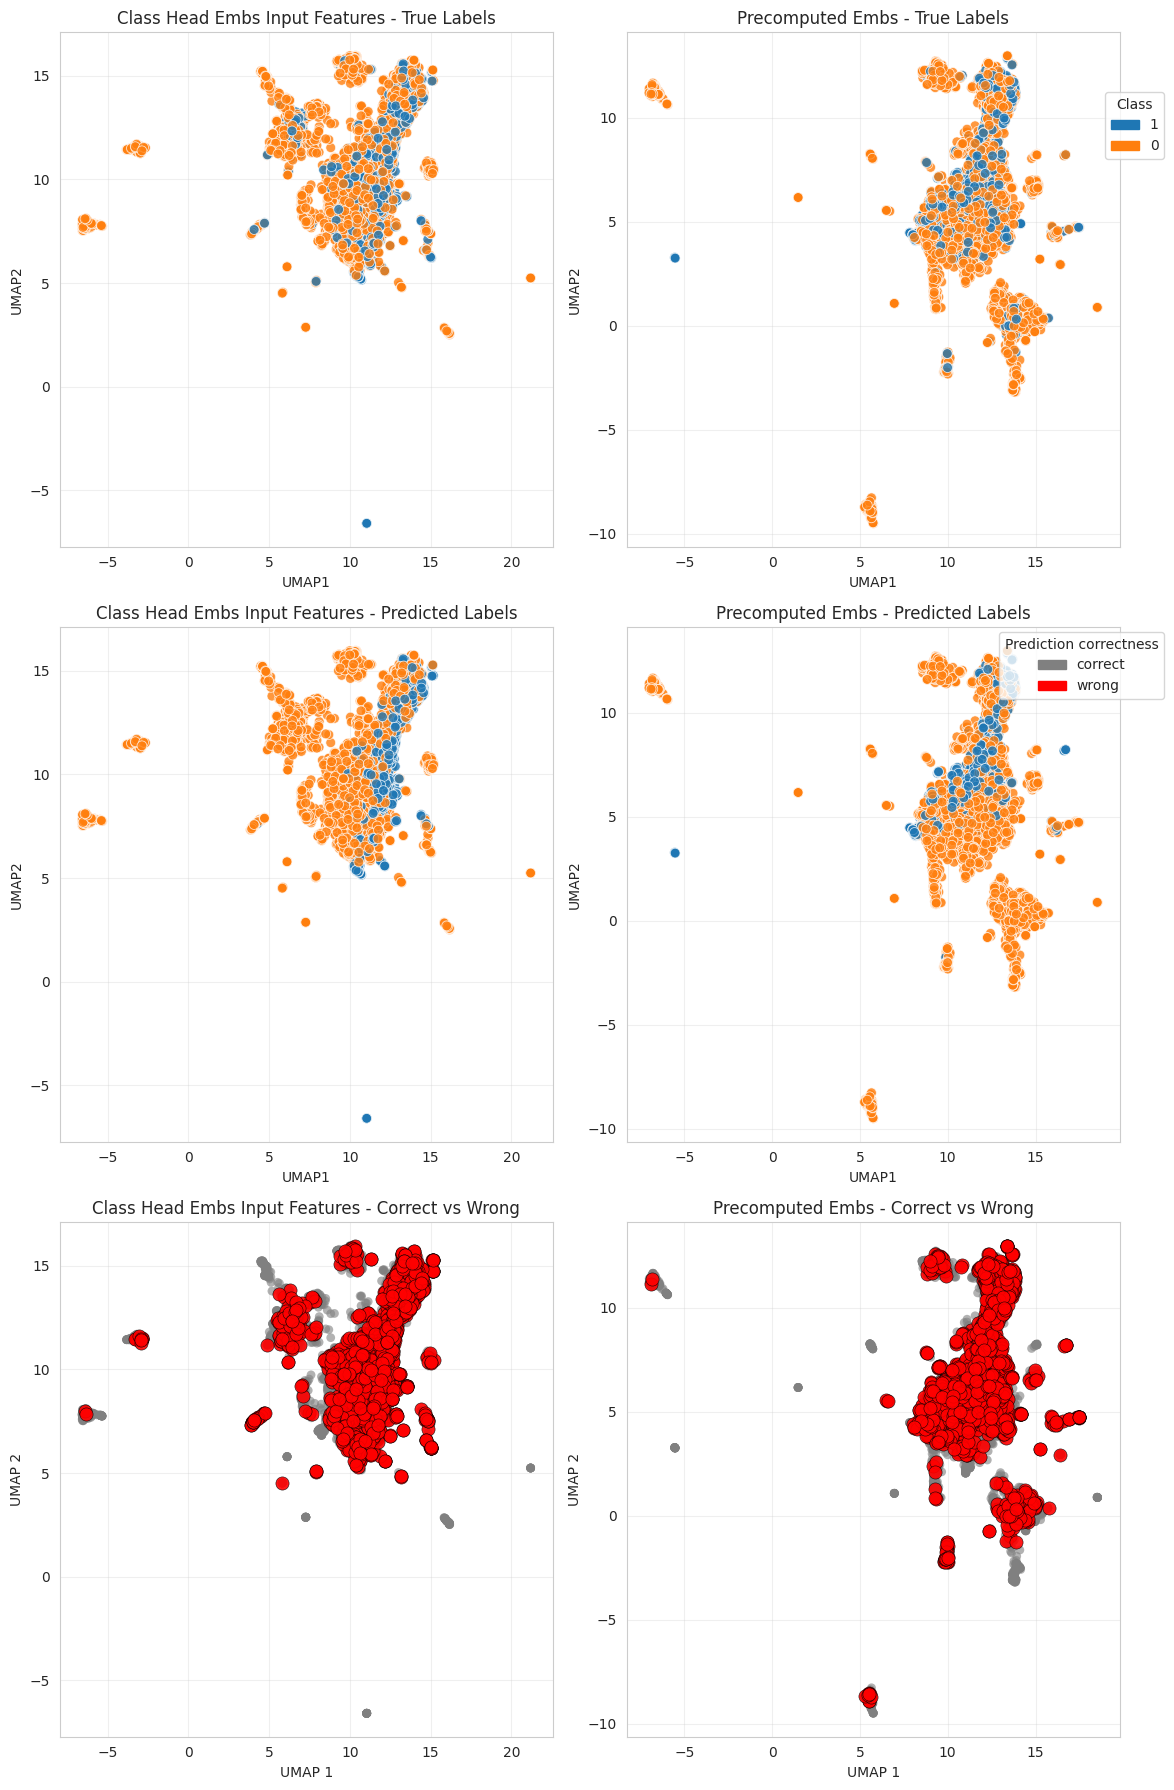

In [19]:
DATALOADER = train_dl

#############################
###### EXTRACT EMBEDDINGS
#############################

print("\nExtracting embeddings from training set...\n")

# Extract embeddings
train_embeddings, names, labels, predictions = my_embs.extract_embeddings(
    net=net,
    dl=DATALOADER,
    device=config["DEVICE"],
    return_numpy=True, # set to False if you want torch tensors instead
    from_precomputed_embs=config["FROM_PRECOMPUTED_EMBS"]
)

print("All possbile embedding given current model architecrure:")
# Example: check shapes
for key, emb in train_embeddings.items():
    if (emb is not None):
        print(f"{key}: {emb.shape}")

# for key, emb in train_embeddings.items():
#     if emb is not None:
#         print(f"\n{key}:")
#         print(f"  Type: {type(emb)}")
#         print(f"  Shape: {emb.shape}")
#         print(f"  Dtype: {emb.dtype}")
#         print(f"  Contains NaN: {np.isnan(emb).any()}")
#         print(f"  Contains Inf: {np.isinf(emb).any()}")
#         print(f"  Min: {np.nanmin(emb) if emb.size > 0 else 'empty'}")
#         print(f"  Max: {np.nanmax(emb) if emb.size > 0 else 'empty'}")
#         print(f"  All NaN: {np.isnan(emb).all()}")
#     else:
#         print(f"\n{key}: None")

#############################
###### CALCULATE UMAP
#############################

print("\nComputing UMAP embeddings...\n")

umap_tensors = my_embs.compute_umap_tensors( #dict of tensors
    embeddings_dict=train_embeddings,
)

#############################
###### PLOT
#############################

print("\nPlotting UMAP embeddings...\n")

if len(list(train_embeddings)) != 0:
    df = my_embs.plot_umap_embeddings(umap_tensors, names, labels, predictions)
else:
    print("No embs to plot")

Clustering complete. Added 'Cluster_Label' column to the DataFrame.
     Name      UMAP1     UMAP2 TrueClass PredClass CorrectStr  Cluster_Label
0  P30990  15.075803  0.645357         0         0    correct              3
1  Q8N2W9  11.272474  7.179921         1         1    correct              4
2  Q8IVV8  11.078135  2.223763         0         0    correct              0
3  O43448  11.525965  4.973000         0         0    correct              5
4  Q8TEC5  12.396820  8.680947         0         1      wrong              4


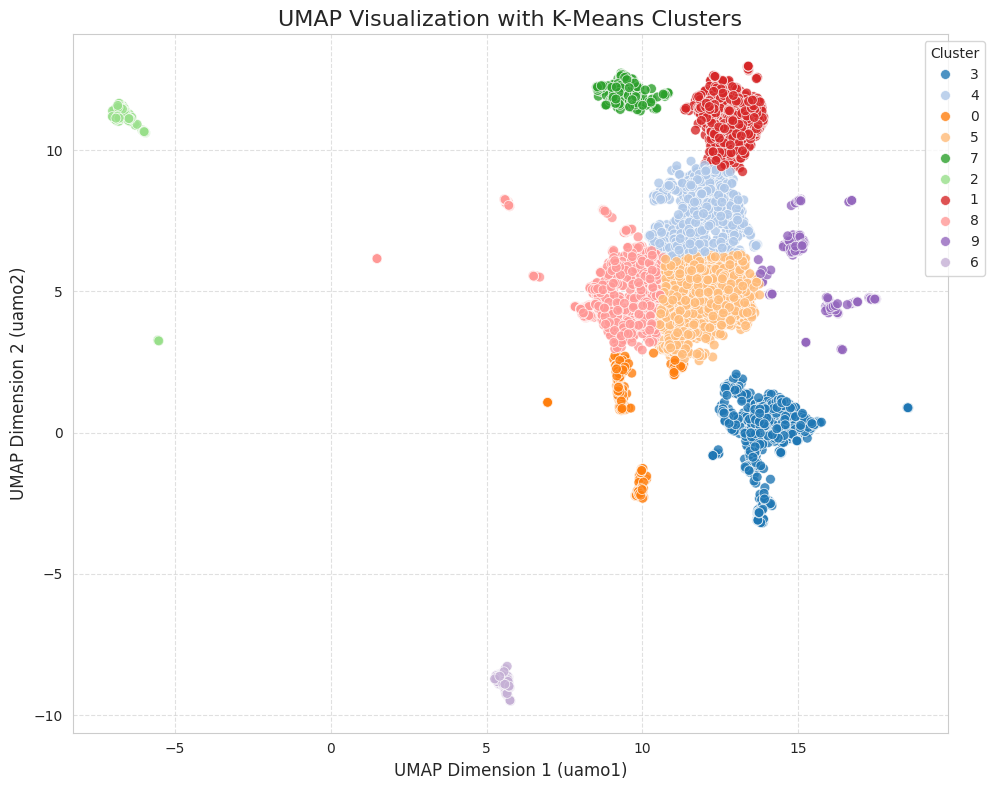

In [25]:
from sklearn.cluster import KMeans

df_precomputed = df["precomputed_embs"].copy()

# Define the features for clustering (the UMAP coordinates)
X_for_clustering = df_precomputed[['UMAP1', 'UMAP2']]

# Define the number of clusters (you should optimize this, e.g., using the Elbow Method)
K = 10

# Initialize and fit the K-Means model
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_for_clustering)

# Save the cluster labels back to the DataFrame
df_precomputed['Cluster_Label'] = cluster_labels
print(f"Clustering complete. Added 'Cluster_Label' column to the DataFrame.")
print(df_precomputed.head())

my_embs.plot_umap_clusters(df_precomputed)

In [ ]:
df_precomputed[df_precomputed.Cluster_Label == 2].Name.to_list() # odortant receptror
df_precomputed[df_precomputed.Cluster_Label == 6].Name.to_list() # Gproteins??
df_precomputed[df_precomputed.Cluster_Label == 7].Name.to_list() #adhesive, matrix

['P29322',
 'P15941',
 'Q93063',
 'Q9Y5E3',
 'P48960',
 'Q99523',
 'P27487',
 'Q8N271',
 'Q8N0W4',
 'Q8TER0',
 'Q9Y5H1',
 'Q70JA7',
 'A4D0S4',
 'O60241',
 'Q6UXX5',
 'Q8TD84',
 'Q68CR7',
 'Q13214',
 'Q9NRJ7',
 'Q9ULF5',
 'Q495T6',
 'Q76B58',
 'Q9UP79',
 'P23471',
 'Q86UX2',
 'Q9HCU4',
 'Q9Y6N7',
 'A8K2U0',
 'O60469',
 'P23470',
 'Q96JQ0',
 'Q9UKG4',
 'O75581',
 'Q15375',
 'Q7Z2K6',
 'P17301',
 'P01031',
 'Q96TA0',
 'Q14416',
 'Q9NRD9',
 'P25092',
 'O94933',
 'Q9UN70',
 'O95672',
 'Q9UBV2',
 'Q9UM73',
 'P08922',
 'Q8IXB1',
 'Q13797',
 'Q2M2H8',
 'Q3V5L5',
 'Q9Y5G6',
 'Q9UF33',
 'Q9HBW9',
 'P01023',
 'Q5VY43',
 'P29400',
 'Q14957',
 'P16109',
 'Q86UK0',
 'Q9Y5F3',
 'Q9UHI8',
 'Q86YT5',
 'Q16706',
 'P05556',
 'O14522',
 'Q15155',
 'Q8NFZ3',
 'Q8IUA7',
 'Q8WWZ7',
 'P78536',
 'Q9P2J2',
 'Q5IJ48',
 'O75093',
 'P08514',
 'Q8NBP0',
 'Q9BXR5',
 'Q9H3T3',
 'Q9H251',
 'P01833',
 'Q9NTN9',
 'Q9ULH4',
 'Q9NRD8',
 'Q5VU97',
 'Q5K4E3',
 'P36269',
 'Q685J3',
 'O43157',
 'O60462',
 'Q6UXI7',
 'P20849',

In [21]:
stop

NameError: name 'stop' is not defined


Extracting embeddings from training set...



All possbile embedding given current model architecrure:
class_head_embs_input_features: (1904, 480)
precomputed_embs: (1904, 480)

Computing UMAP embeddings...

Computing UMAP for class_head_embs_input_features with shape (1904, 480)...
Computing UMAP for precomputed_embs with shape (1904, 480)...

Plotting UMAP embeddings...



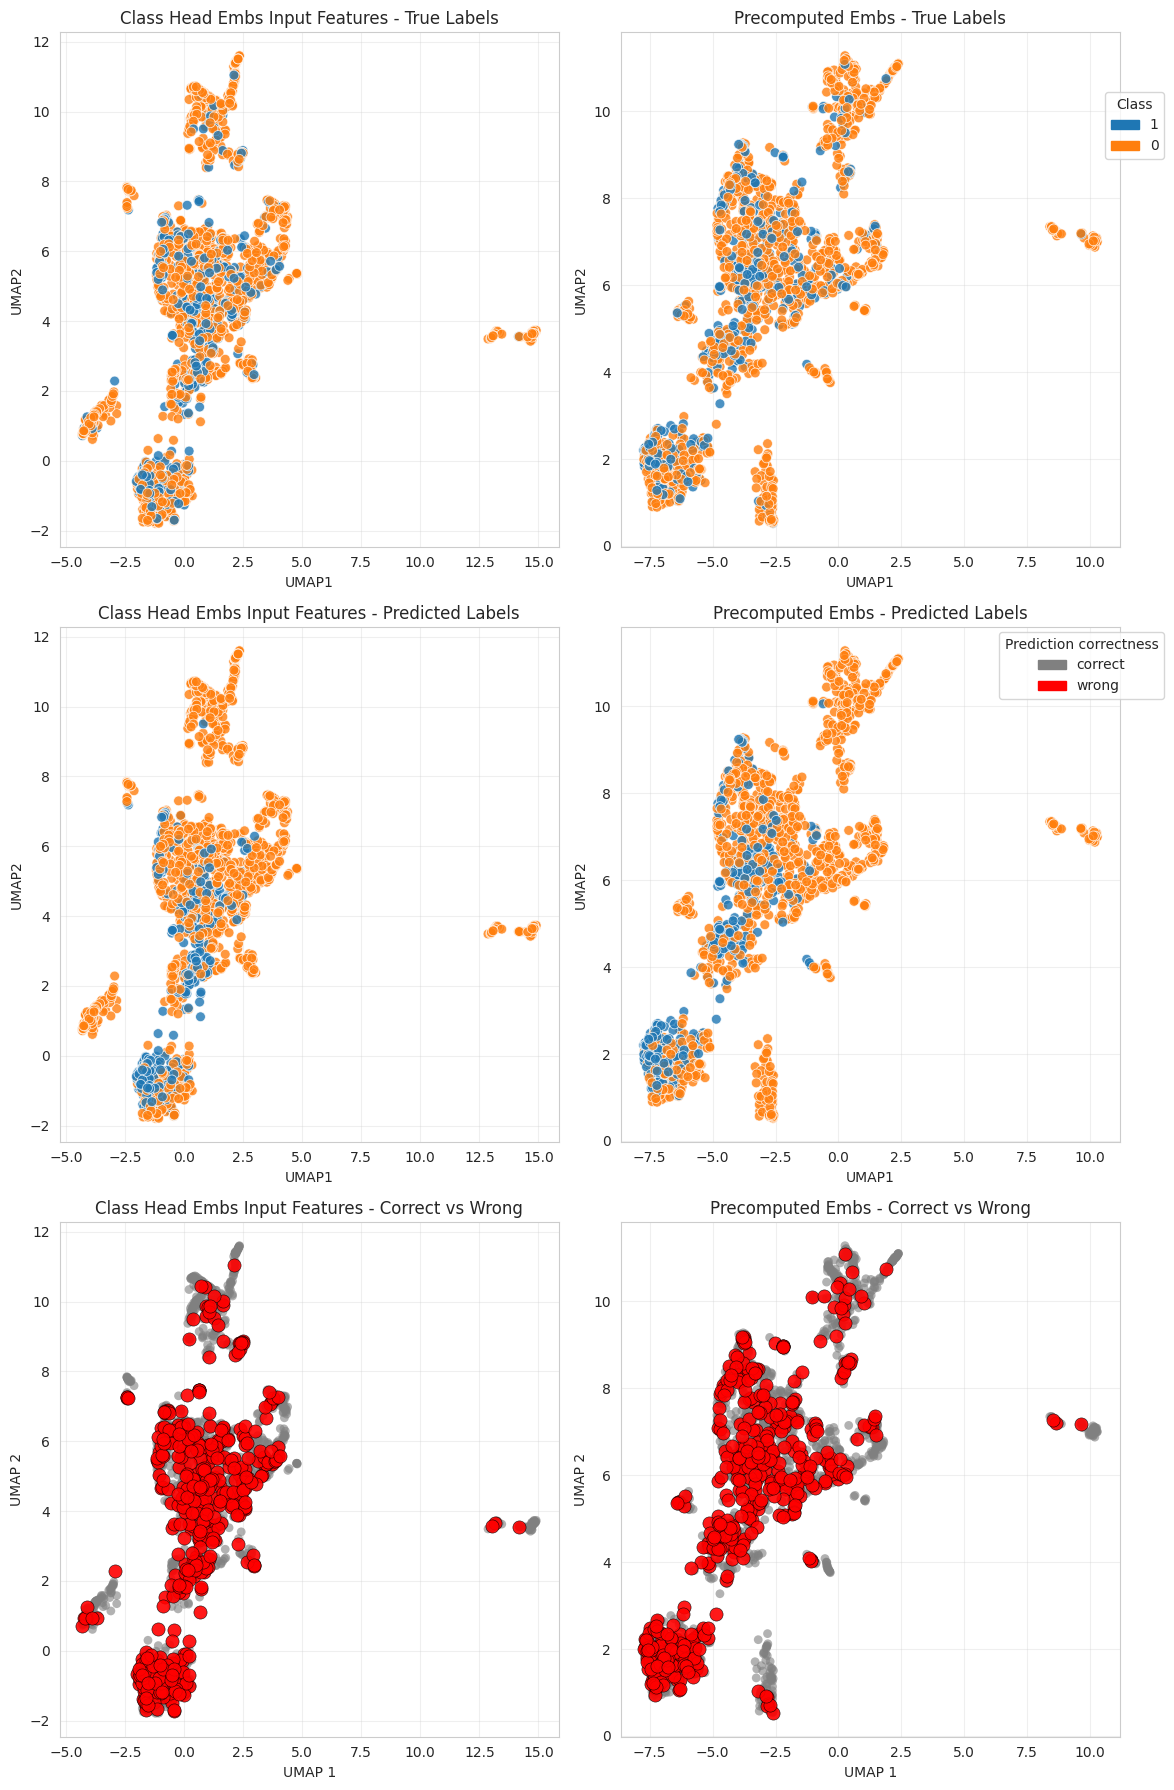

In [ ]:
DATALOADER = test_dl

#############################
###### EXTRACT EMBEDDINGS
#############################

print("\nExtracting embeddings from training set...\n")

# Extract embeddings
train_embeddings, names, labels, predictions = my_embs.extract_embeddings(
    net=net,
    dl=DATALOADER,
    device=config["DEVICE"],
    return_numpy=True, # set to False if you want torch tensors instead
    from_precomputed_embs=config["FROM_PRECOMPUTED_EMBS"]
)

print("All possbile embedding given current model architecrure:")
# Example: check shapes
for key, emb in train_embeddings.items():
    if (emb is not None):
        print(f"{key}: {emb.shape}")

#############################
###### CALCULATE UMAP
#############################

print("\nComputing UMAP embeddings...\n")

umap_tensors = my_embs.compute_umap_tensors( #dict of tensors
    embeddings_dict=train_embeddings,
)

#############################
###### PLOT
#############################

print("\nPlotting UMAP embeddings...\n")

if len(list(train_embeddings)) != 0:
    df = my_embs.plot_umap_embeddings(umap_tensors, names, labels, predictions)
else:
    print("No embs to plot")

In [ ]:
df_tmp = df["precomputed_embs"]
df_tmp[(df_tmp["CorrectStr"] == "correct") & (df_tmp["TrueClass"] == "1")]

#df[df['CorrectStr'] == 'correct']


,Name,UMAP1,UMAP2,TrueClass,PredClass,CorrectStr
7,Q99570,-6.443100,1.047492,1,1,correct
8,O94805,-4.047790,6.537436,1,1,correct
25,Q16665,-7.100338,2.213771,1,1,correct
27,Q8WYJ6,-2.456433,6.293162,1,1,correct
51,P53675,-7.613284,1.956934,1,1,correct
...,...,...,...,...,...,...
1860,Q15431,-7.494800,2.264595,1,1,correct
1862,P25054,-7.276444,1.884682,1,1,correct
1888,O94913,-7.384957,2.388320,1,1,correct
1899,Q99459,-7.541768,2.340592,1,1,correct


# A-scanning

In [ ]:
PROTEIN = "P11802" #df[(df["CorrectStr"] == "correct") & (df["TrueClass"] == "1")].iloc[0].Name
    # Q4QAE3
#"A0A8V8TKW5" #"P39039" # "Q91VU0"
WINDOW_SIZE_FRACTION = 0.01 # 10% of sequence length
SUBSTITUTE_AA = ["A", "R", "E", "F"] #"<pad>", "A", "P"
WINDOW_SIZE_SUBSTITUION = 5 #int(single_protein_info.trunc_sequence_length * WINDOW_SIZE_FRACTION // 2 * 2 + 1) # make it odd
print("window size: ", WINDOW_SIZE_SUBSTITUION)

##############################

net.from_precomputed_embs = False # need to recompute embs for each mutation
# ATTNETION: use SAME intial embs (embs passed to calssfricvation head) used IN TRAINING!!
net.type_emb_for_classification = config["TYPE_EMB_FOR_CLASSIFICATION"] 

##############################
# select single port data

idx = [cache_data["protein"].index(PROTEIN)] # encapslu in a lsit
selected_protein_data = my_dataset.subset_data_dict(cache_data, idx)
#print(selected_protein_data)

##############################
# calcualte baseline prob

baseline_prob = my_scanning.get_prob_single_protein(net, selected_protein_data, device="cuda")
print(baseline_prob)

##############################
# create all mutatios

all_mutated_seqs = my_scanning.create_all_mutations(selected_protein_data["truncated_sequence"][0], WINDOW_SIZE_SUBSTITUION, SUBSTITUTE_AA)
tot_mutations = len(all_mutated_seqs)
print(tot_mutations,  len(list(selected_protein_data["truncated_sequence"][0])) * len(SUBSTITUTE_AA))

# create dict
cache_mutations = {
    "protein": [selected_protein_data["protein"][0]] * tot_mutations,
    "label": torch.tensor([selected_protein_data["label"][0]] * tot_mutations),
    "set": [selected_protein_data["set"][0]] * tot_mutations,
    "sequence": all_mutated_seqs, 
    "truncated_sequence": all_mutated_seqs, 
}
# tokenize AS ABOVE (start ntoebook)
encoded = tokenizer(
    list(cache_mutations["truncated_sequence"]),
    padding='max_length',
    max_length=config["PROTEIN_MAX_LENGTH"],
    truncation=True,
    return_tensors="pt"
)
# add to dict
cache_mutations['input_ids'] =  encoded["input_ids"]  
cache_mutations[ 'attention_mask'] =  encoded["attention_mask"]
# ATTNETION: fake embs, as force to calculte here
cache_mutations["embedding"] = torch.zeros((tot_mutations, 1), dtype=torch.float32)



window size:  5


Evaluation:   0%|          | 0/1 [00:00<?, ? Single protein batch/s]

0.6345576047897339


Generating mutations:   0%|          | 0/303 [00:00<?, ?it/s]

1212 1212


In [ ]:
scan_results = my_scanning.multi_aa_scanning_final(
    model=net,
    baseline_prob=baseline_prob,
    cache_mutations=cache_mutations,
    substitute_aas=SUBSTITUTE_AA,
    window_size=WINDOW_SIZE_SUBSTITUION,
    normalise_true_substitution=False,
    device="cuda"
)

Evaluation:   0%|          | 0/19 [00:00<?, ? mutations batch/s]

KeyboardInterrupt: 

In [ ]:
my_scanning.plot_multi_aa_scan(scan_results, show_per_aa=False)

In [ ]:
selected_protein_data

# AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
# AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

### A-scanning Logits

In [ ]:
def prob_to_logit(p):
    """
    Convert probability of class 1 to logit (binary case)
    p: float or np.array of probabilities (0 < p < 1)
    returns: logit value(s)
    """
    p = np.clip(p, 1e-15, 1 - 1e-15)  # avoid log(0)
    return np.log(p / (1 - p))


PROTEIN = "P05997" #"Q6ZRI0" #"P01270" #"O60938" #"P05997"
WINDOW_SIZE_FRACTION = 0.01 # 10% of sequence length
SUBSTITUTE_AA = "A" #"<pad>", "A", "P"

# Extract info
single_protein_info = data_df[data_df['protein'] == PROTEIN].iloc[0]
display(single_protein_info)

WINDOW_SIZE_SUBSTITUION = int(single_protein_info.trunc_sequence_length * WINDOW_SIZE_FRACTION // 2 * 2 + 1) # make it odd
print(WINDOW_SIZE_SUBSTITUION)

# Run alanine scanning
results = mf.alanine_scanning(
    model=net,
    tokenizer=tokenizer,
    single_protein_info=single_protein_info,
    window_size=WINDOW_SIZE_SUBSTITUION, # make it odd
    device=config["DEVICE"],
    SUBSTITUTE_AA=SUBSTITUTE_AA,
    normalise_true_substitution=True #normalise by number of true substitutions (not A->A
)

# calcuate logits
baseline_logit = prob_to_logit(results['baseline_prob'])
mutated_logits = prob_to_logit(results['mutated_probs'])
delta_logit = mutated_logits - baseline_logit

mf.plot_alanine_scan(
    delta_p=delta_logit,
    sequence=results['sequence'],
    protein_name=results['protein_name'],
    sigma=3,
    threshold=True,
    highlight_residues=True,
    top_n=10,
    show_sequence=False,
    style='whitegrid'  # Options: 'darkgrid', 'whitegrid', 'dark', 'white', 'ticks'
)

### Random prot

In [ ]:
random_prot = "MVMAAAKKNMQQLDSFKGDDSIDHEIATPYSWQRKFSGESKAIALGMYGTKMISCGQWRDQACYILYWVFWYPYFNVSQESIVLQYDLPHYGYDIFKPYINQTARCCPHHPQEAMNSEGNTVPACYAAVGQADPPIFDIAYSIMILRPLYGTCNPTGFQNVMNAIWSEEMAMFTQTHYVLPYRYPYQTYRLTSFSSRIMMENAGACEWESMVNFIFRTVAKRCKDKEYLFGNCAWTRLWSIAPHQWKWPSKNTHMYIDHFVEKGKQEELSNASWHTYLATSICPAHHHDWVWWNFEFWLCHFTEMDT"
random_label = 0
random_name = "Random_Prot"
random_data = pd.DataFrame([{
    'sequence': random_prot,
    'label': random_label,
    'protein': random_name,
    'set': 'test'
}])

# Preprocess each sequence individually
random_preprocessed_data = []
for idx, row in tqdm(random_data.iterrows(), total=len(random_data)):
    processed = my_dataset.preprocess_sequence(
        sequence=row['sequence'],
        label=row['label'],
        protein_name=row['protein'],
        tokenizer=tokenizer,
        protein_max_length=config["PROTEIN_MAX_LENGTH"]
    )
    random_preprocessed_data.append(processed)

# Create DataFrame from preprocessed data
random_data_df = pd.DataFrame(random_preprocessed_data)

# Add the 'set' column back from original data
random_data_df['set'] = random_data['set'].values

############################################

random_dl = my_dataset.create_dataloader(random_data_df, 'test', config["BATCH_SIZE"], shuffle=True)

# Optional: inspect the DataFrame
display(random_data_df.head(5))
#print(random_data_df.loc[0, "input_ids"])

In [ ]:
outputs = mf.evaluate_model(net, random_dl, config["DEVICE"], loss_fn=None, split_name="Eval", verbose=True)
outputs

### Calibration

In [ ]:
outputs = mf.evaluate_model(net, test_dl, config["DEVICE"], loss_fn=loss_fn, split_name="Eval", verbose=True)
outputs

In [ ]:
probs = outputs['probs_class1']
print(probs)
sns.histplot(probs, kde=False, bins=30)  # kde=True if you also want a density curve
plt.show()

In [ ]:
# Calibration curve

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# y_true: 0 or 1 labels for your proteins
# y_prob: predicted probabilities for class 1

#x-axis = average predicted probability in that bin.
#y-axis = true fraction positive in that bin.

prob_true, prob_pred = calibration_curve(y_true=outputs['labels'], y_prob=outputs['probs_class1'], n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label="Model")
plt.plot([0,1],[0,1], linestyle="--", label="Perfect calibration")
plt.xlabel("Predicted probability")
plt.ylabel("True fraction positive")
plt.title("Reliability diagram")
plt.legend()
plt.show()
